In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPool2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
%matplotlib inline

In [2]:
def acc_plot(history, name):
    plt.figure(figsize=(10,6))
    plt.plot(history['accuracy'], label='training accuracy')
    plt.plot(history['loss'], label='training loss')    
    plt.plot(history['val_accuracy'], label='validation accuracy')
    plt.plot(history['val_loss'], label='validation loss')
    plt.title(name + ' Accuracy and Loss')
    plt.xlabel('epochs')
    plt.legend()
#     plt.savefig(name +'_Result.png', bbox_inches='tight', dpi=300)
    return plt.show()
    
def gen_csv(model, name):
    result = dfTest[['Id']].copy()
    X_test = np.dstack([np.array(dfTest.iloc[:, 1:])] * 3).reshape(-1, 28, 28, 3)
    X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in X_test]).astype('float32')/255
    result['Label'] = np.argmax(model.predict(X_test), axis=1)
    result.to_csv('result' + name + '.csv', encoding='utf-8', index=False)
    
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    pool = MaxPool2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out
 
# define model input
visible = Input(shape=(64, 64, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

for fc in [256, 128]:
    layer = Dense(fc, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
layer = Flatten()(layer)
predictions = Dense(5, activation='softmax')(layer)

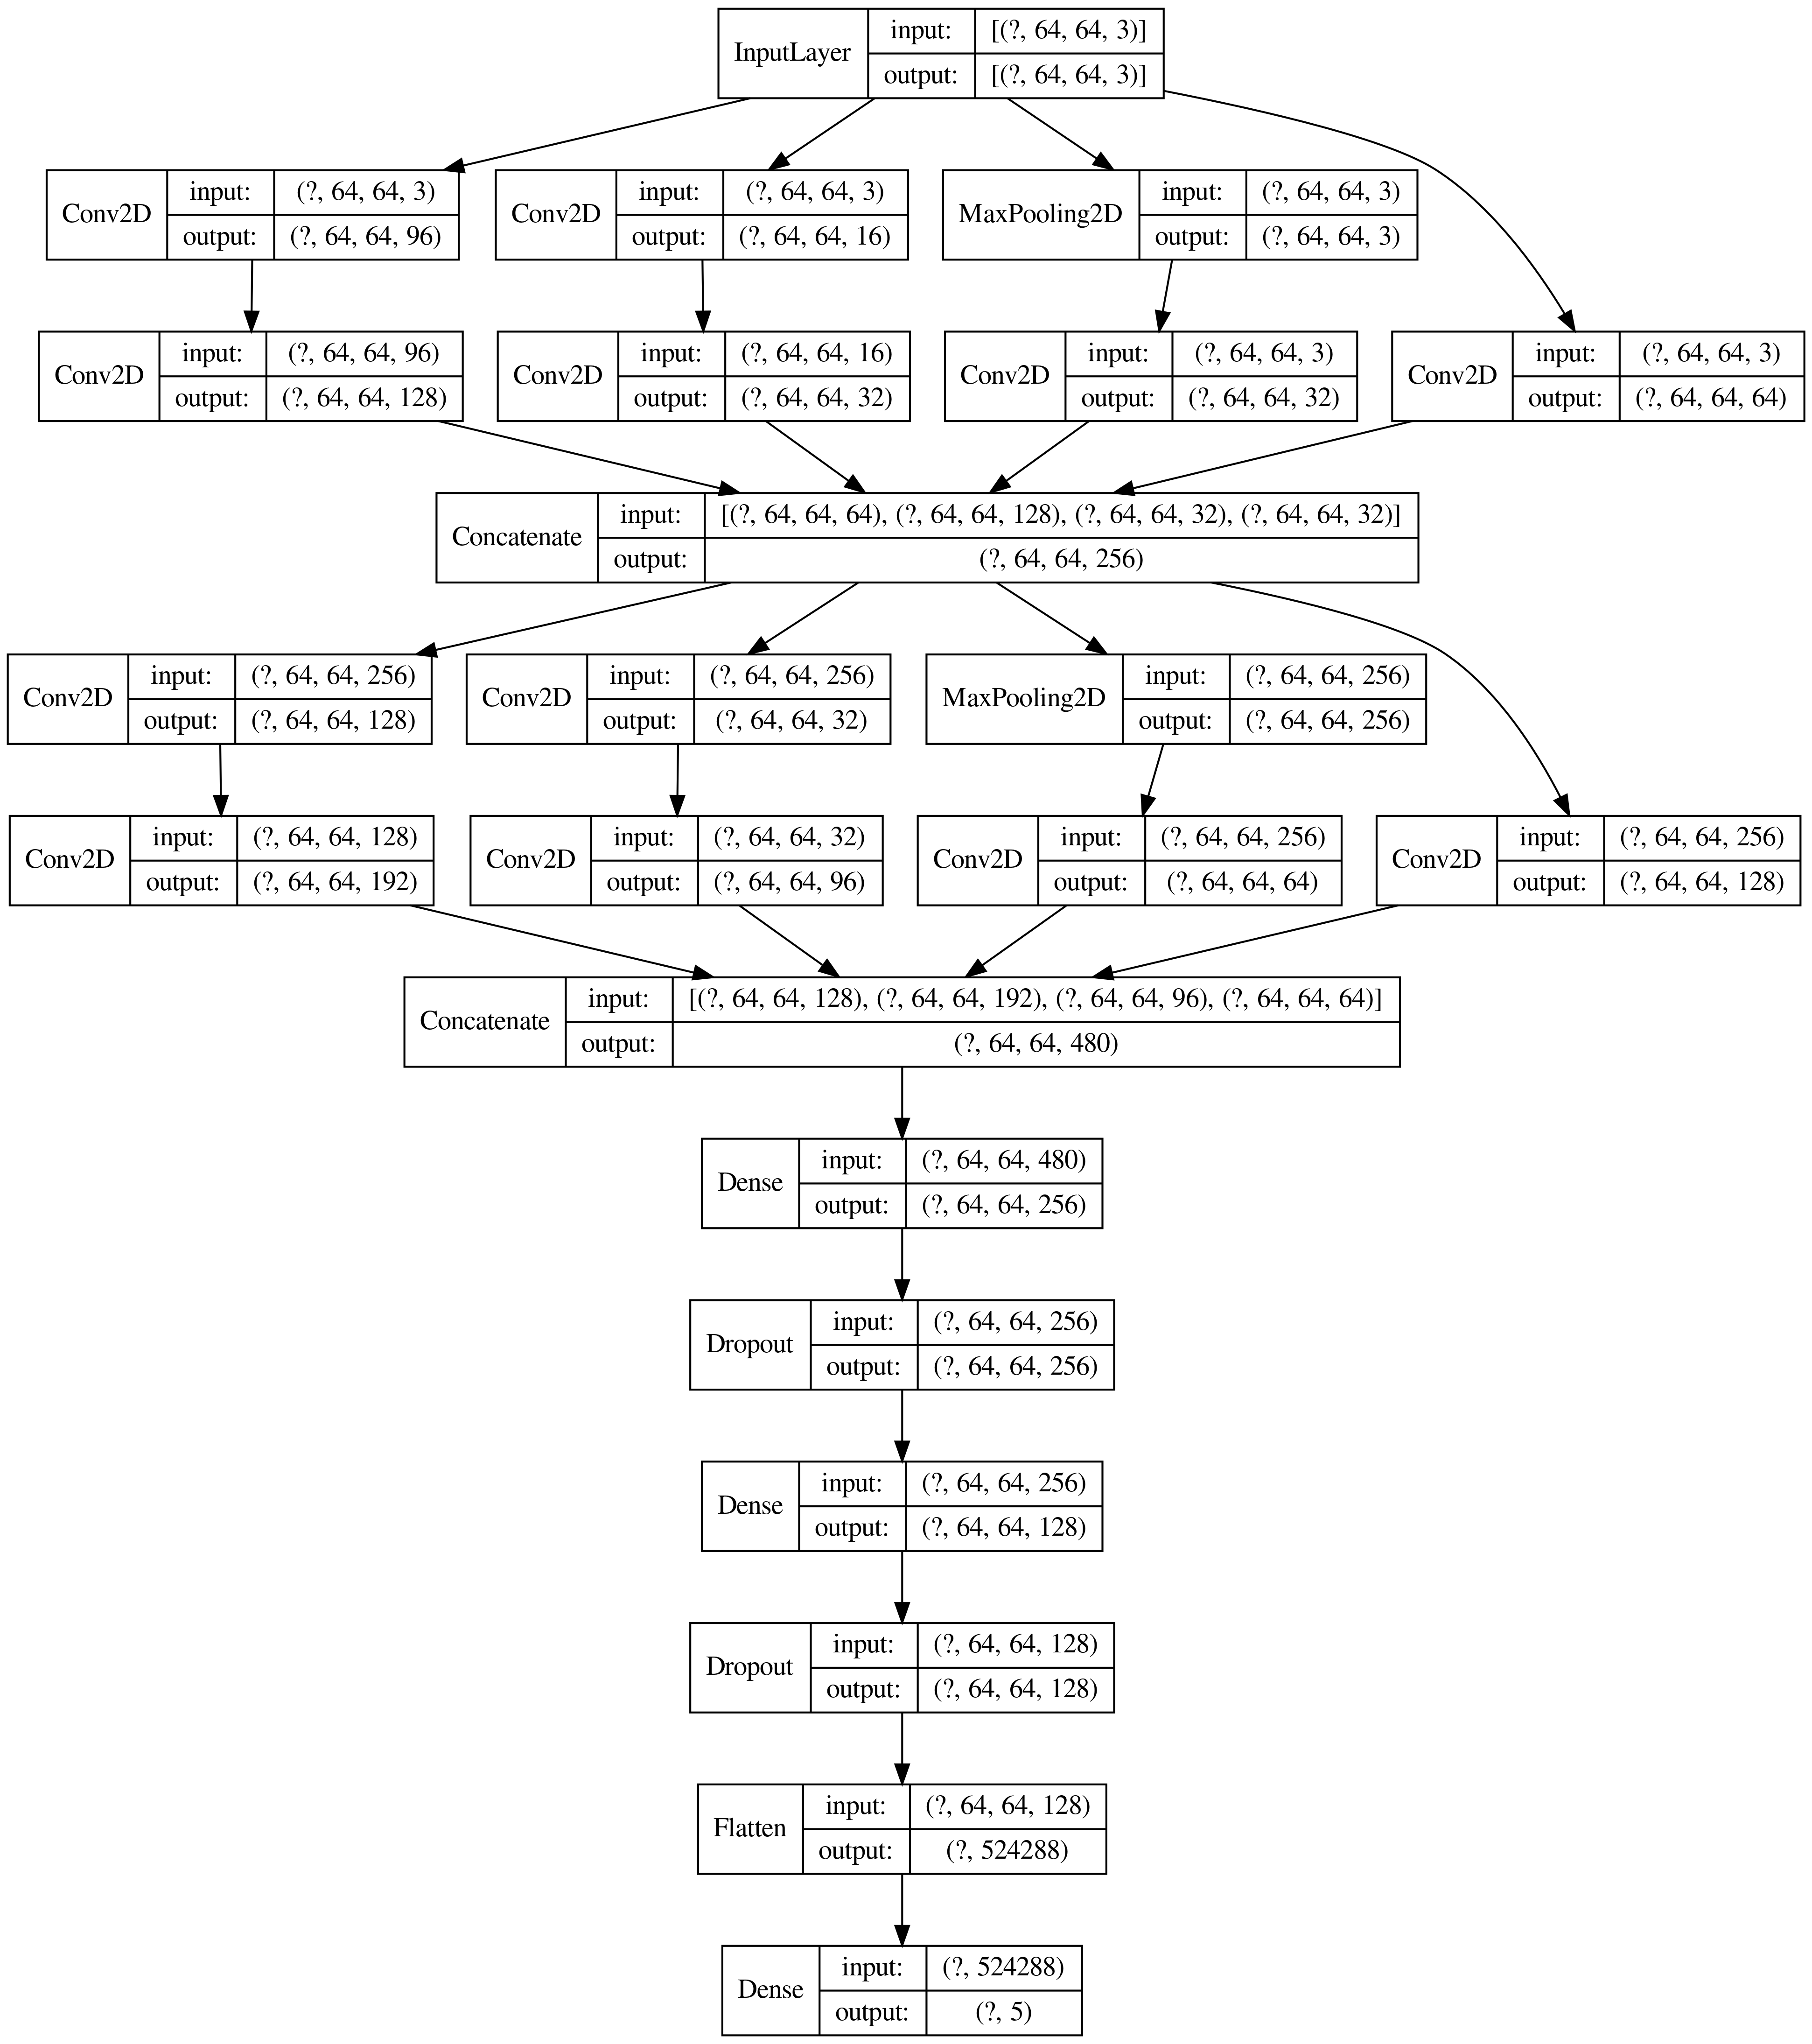

In [3]:
inception = Model(inputs=visible, outputs=predictions)
plot_model(model = inception, to_file='Inception.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=300)

In [3]:
df = pd.read_csv('train.csv').drop(columns=['Id'])
dfTest = pd.read_csv('testX.csv')
X = np.array(df.iloc[:, 1:])
y = to_categorical(np.array(df.iloc[:, 0]))

X = np.dstack([X] * 3).reshape(-1, 28, 28, 3)
X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in X]).astype('float32')/255
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 169s 4ms/sample - loss: 0.6680 - accuracy: 0.7217 - val_loss: 0.6068 - val_accuracy: 0.7401
Epoch 2/25
48000/48000 [==============================] - 165s 3ms/sample - loss: 0.5064 - accuracy: 0.7915 - val_loss: 0.5060 - val_accuracy: 0.7874
Epoch 3/25
48000/48000 [==============================] - 165s 3ms/sample - loss: 0.4670 - accuracy: 0.8098 - val_loss: 0.4797 - val_accuracy: 0.8109
Epoch 4/25
48000/48000 [==============================] - 165s 3ms/sample - loss: 0.4293 - accuracy: 0.8253 - val_loss: 0.4750 - val_accuracy: 0.8070
Epoch 5/25
48000/48000 [==============================] - 165s 3ms/sample - loss: 0.3996 - accuracy: 0.8379 - val_loss: 0.4578 - val_accuracy: 0.8166
Epoch 6/25
48000/48000 [==============================] - 165s 3ms/sample - loss: 0.3795 - accuracy: 0.8459 - val_loss: 0.4471 - val_accuracy: 0.8217
Epoch 7/25
48000/48000 [==========================

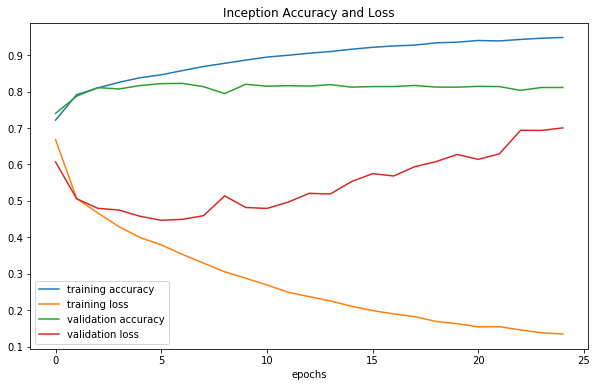

In [4]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
inception = Model(inputs=visible, outputs=predictions)
inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
historyInception = inception.fit(X_train, y_train, epochs = 25, batch_size = 32, verbose = 1, validation_data=(X_val, y_val), callbacks = [reduce_lr])
acc_plot(historyInception.history, 'Inception')
gen_csv(inception, 'Inception')